In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm


# ================================
# Initialisation MediaPipe Hands
# ================================
mp_hands = mp.solutions.hands

def initialize_model():
    return mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=MAX_HANDS,
        min_detection_confidence=0.7
    )

# ================================
# Extraire les keypoints de la main
# ================================
def extract_hand_keypoints(image, hands_model):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = hands_model.process(image_rgb)
    if result.multi_hand_landmarks:
        landmarks = result.multi_hand_landmarks[0]
        return np.array([[lm.x, lm.y, lm.z] for lm in landmarks.landmark]).flatten()
    return None

# ================================
# Traitement d'une image
# ================================
def process_image(image_path, hands_model):
    image = cv2.imread(image_path)
    if image is None:
        return None
    return extract_hand_keypoints(image, hands_model)

# ================================
# Traitement de tout le dataset
# ================================
def process_dataset(dataset_path, output_path):
    hands_model = initialize_model()

    os.makedirs(output_path, exist_ok=True)

    for label in tqdm(sorted(os.listdir(dataset_path)), desc="Traitement des lettres"):
        label_input_path = os.path.join(dataset_path, label)
        label_output_path = os.path.join(output_path, label)

        if not os.path.isdir(label_input_path):
            continue

        os.makedirs(label_output_path, exist_ok=True)

        for idx, img_file in enumerate(os.listdir(label_input_path)):
            img_path = os.path.join(label_input_path, img_file)
            keypoints = process_image(img_path, hands_model)
            if keypoints is not None:
                output_file = os.path.join(label_output_path, f"{idx}.npy")
                np.save(output_file, keypoints)




In [1]:
# ================================
# Configurations
# ================================
#DATASET_PATH = r"C:\Users\LENOVO\Desktop\SDIA_S2_Mast\IA et Projet\ASL_Alphabet_Dataset\asl_alphabet_train"           
OUTPUT_PATH = "data_process"          
MAX_HANDS = 1

In [2]:
import os
import numpy as np

def load_dataset(processed_path="processed"):
    X = []
    y = []
    labels = sorted(os.listdir(processed_path))  # ['A', 'B', ..., 'Z']
    label_to_index = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        label_dir = os.path.join(processed_path, label)
        for file in os.listdir(label_dir):
            if file.endswith(".npy"):
                path = os.path.join(label_dir, file)
                X.append(np.load(path))
                y.append(label_to_index[label])

    return np.array(X), np.array(y), label_to_index


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y, label_map = load_dataset(OUTPUT_PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [6]:
X_train.shape

(112662, 63)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.99162110345807


In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
# -------------------------------
# SVM
# -------------------------------
clf_svm = SVC(kernel='linear')
clf_svm.fit(X_train, y_train)

y_pred_svm = clf_svm.predict(X_test)
print("\n=== SVM (Support Vector Machine) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


=== SVM (Support Vector Machine) ===
Accuracy: 0.9854789462472484
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       984
           1       1.00      1.00      1.00      1137
           2       0.98      0.99      0.99       854
           3       0.99      1.00      0.99      1131
           4       0.99      0.99      0.99       997
           5       1.00      1.00      1.00      1497
           6       0.98      0.99      0.99      1125
           7       0.99      0.99      0.99      1125
           8       0.98      0.97      0.98      1084
           9       0.99      0.98      0.99      1038
          10       0.98      0.99      0.99      1287
          11       1.00      1.00      1.00      1276
          12       0.90      0.94      0.92       538
          13       0.95      0.89      0.92       473
          14       0.99      0.99      0.99       952
          15       0.99      0.99      0.99 

In [35]:
from sklearn.metrics import classification_report

labels = sorted(set(y_test))  # classes réellement présentes dans y_test
target_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1]) if v in labels]

print(classification_report(y_test, y_pred, labels=labels, target_names=target_names))


              precision    recall  f1-score   support

           A       0.99      0.99      0.99       984
           B       0.99      1.00      1.00      1137
           C       0.99      0.99      0.99       854
           D       1.00      0.99      1.00      1131
           E       0.99      0.99      0.99       997
           F       1.00      1.00      1.00      1497
           G       1.00      0.99      1.00      1125
           H       0.99      1.00      0.99      1125
           I       0.99      0.99      0.99      1084
           J       1.00      1.00      1.00      1038
           K       0.99      0.99      0.99      1287
           L       1.00      1.00      1.00      1276
           M       0.96      0.99      0.97       538
           N       0.98      0.95      0.97       473
           O       0.99      0.99      0.99       952
           P       1.00      1.00      1.00       888
           Q       1.00      1.00      1.00       887
           R       0.99    

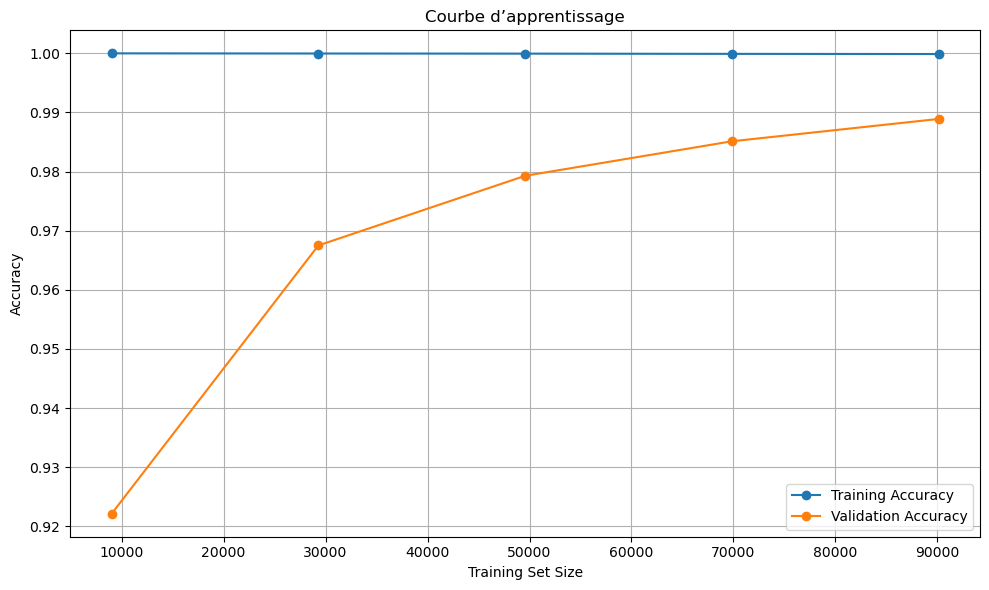

In [12]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Courbe d’apprentissage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
label_map

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

In [36]:
# ----------------------
# Fonction pour prédire sur une image unique (test manuel)
# ----------------------
def predict_image(image_path, hands_model, scaler, model, label_map):
    # Inverser label_map pour mapping int -> string
    inv_label_map = {v: k for k, v in label_map.items()}
    
    keypoints = process_image(image_path, hands_model)
    if keypoints is None:
        print("Keypoints non extraits.")
        return None
    
    keypoints_scaled = scaler.transform([keypoints])  # scaler attend un tableau 2D
    pred = model.predict(keypoints_scaled)[0]
    label_pred = inv_label_map.get(pred, "Inconnu")  # Utiliser mapping inversé ici
    print(f"Prédiction : {label_pred}")
    return label_pred

# Usage
import mediapipe as mp
mp_hands = mp.solutions.hands
hands_model = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.7)

image_test = r"C:\Users\LENOVO\Desktop\SDIA_S2_Mast\IA et Projet\ASL_Alphabet_Dataset\asl_alphabet_train\A\1.jpg"
predict_image(image_test, hands_model, scaler, clf, label_map)


Prédiction : A


'A'

In [37]:
import os

def test_multiple_images(test_folder, hands_model, scaler, model, label_map):
    for img_file in os.listdir(test_folder):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(test_folder, img_file)
            print(f"Image : {img_file}")
            pred = predict_image(img_path, hands_model, scaler, model, label_map)
            print("---")

# Exemple d’utilisation :
test_folder = r"C:\Users\LENOVO\Desktop\SDIA_S2_Mast\IA et Projet\ASL_Alphabet_Dataset\asl_alphabet_test"

test_multiple_images(test_folder, hands_model, scaler, clf, label_map)


Image : A_test.jpg
Keypoints non extraits.
---
Image : B_test.jpg
Prédiction : B
---
Image : C_test.jpg
Keypoints non extraits.
---
Image : D_test.jpg
Keypoints non extraits.
---
Image : E_test.jpg
Keypoints non extraits.
---
Image : F_test.jpg
Prédiction : F
---
Image : G_test.jpg
Prédiction : G
---
Image : H_test.jpg
Keypoints non extraits.
---
Image : I_test.jpg
Prédiction : I
---
Image : J_test.jpg
Prédiction : J
---
Image : K_test.jpg
Prédiction : K
---
Image : L_test.jpg
Prédiction : L
---
Image : M_test.jpg
Keypoints non extraits.
---
Image : nothing_test.jpg
Keypoints non extraits.
---
Image : N_test.jpg
Keypoints non extraits.
---
Image : O_test.jpg
Keypoints non extraits.
---
Image : P_test.jpg
Keypoints non extraits.
---
Image : Q_test.jpg
Prédiction : Q
---
Image : R_test.jpg
Keypoints non extraits.
---
Image : space_test.jpg
Keypoints non extraits.
---
Image : S_test.jpg
Prédiction : S
---
Image : T_test.jpg
Prédiction : T
---
Image : U_test.jpg
Keypoints non extraits.
---

In [39]:
from joblib import dump, load
dump(clf, 'model_rf.joblib')
dump(scaler, 'scaler.joblib')
#clf_loaded = load('model_rf.joblib')


['scaler.joblib']

In [ ]:
from joblib import load
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Charger le modèle et le scaler
clf = load('model_rf.joblib')
scaler = load('scaler.joblib')

# Transformer le jeu de test avec le scaler chargé
X_test_scaled = scaler.transform(X_test)

# Générer les prédictions
y_pred = clf.predict(X_test_scaled)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
import matplotlib.pyplot as plt
plt.show()
